# Using NN to study the Ising model phase transition

Notebook based on the paper:

**Machine learning phases of matter.** ([Link](http://arxiv.org/abs/1605.01735%0Ahttp://dx.doi.org/10.1038/nphys4035))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
import sys, os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [87]:
#plt.rcParams['figure.figsize'] = [6.32, 5.11]
#plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
path = '../Data/'

In [4]:
L = 40
temp_val = np.arange(0.25, 4.0001, 0.25)
temp_samples = 10000
total_samples = temp_samples * temp_val.shape[0]
test_size = 0.1
val_size = 0.2

In [5]:
split_tc = False

In [6]:
data = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All.pkl','rb'))
data = np.unpackbits(data).reshape(-1, L * L).astype(int)
#data[np.where(data==0)]=-1

labels = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))

In [7]:
first_tc = np.where(temp_val <= 2.)[0][-1] * temp_samples
last_tc = np.where(temp_val >= 3)[0][1] * temp_samples

In [8]:
temp_labels = np.hstack([np.repeat(temp, temp_samples) for temp in temp_val])

In [9]:
if split_tc:
    
    X_ordered = data[:first_tc, :]
    Y_ordered = np.column_stack((labels[:first_tc], temp_labels[:first_tc]))

    X_critical = data[first_tc:last_tc, :]
    Y_critical = np.column_stack((labels[first_tc:last_tc], temp_labels[first_tc:last_tc]))

    X_disordered = data[last_tc:, :]
    Y_disordered = np.column_stack((labels[last_tc:], temp_labels[last_tc:]))

    X = np.concatenate((X_ordered, X_disordered))
    Y = np.concatenate((Y_ordered, Y_disordered))
    
    del X_ordered, Y_ordered, X_disordered, Y_disordered, data, labels

else:
    
    X = data
    Y = np.column_stack((labels, temp_labels))
    
    del data, labels

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

del X, Y

In [11]:
model = Sequential()
model.add(Dense(100, input_shape=(L * L, ), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               160100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 160,201
Trainable params: 160,201
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, Y_train[:, 0], validation_data=(X_val, Y_val[:, 0]) , batch_size=64, epochs=5)


Train on 115200 samples, validate on 28800 samples
Epoch 1/5
115200/115200 [==============================] - 7s 58us/step - loss: 0.4980 - accuracy: 0.8808 - val_loss: 0.2204 - val_accuracy: 0.9800
Epoch 2/5
115200/115200 [==============================] - 4s 37us/step - loss: 0.1145 - accuracy: 0.9844 - val_loss: 0.0558 - val_accuracy: 0.9919
Epoch 3/5
115200/115200 [==============================] - 4s 37us/step - loss: 0.0772 - accuracy: 0.9876 - val_loss: 0.0601 - val_accuracy: 0.9922
Epoch 4/5
115200/115200 [==============================] - 4s 39us/step - loss: 0.0759 - accuracy: 0.9876 - val_loss: 0.0587 - val_accuracy: 0.9918
Epoch 5/5
115200/115200 [==============================] - 4s 38us/step - loss: 0.0891 - accuracy: 0.9834 - val_loss: 0.0736 - val_accuracy: 0.9931


In [14]:
score = model.evaluate(X_test, Y_test[:, 0], verbose=0)
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 0.9924 
Test loss: 0.0751


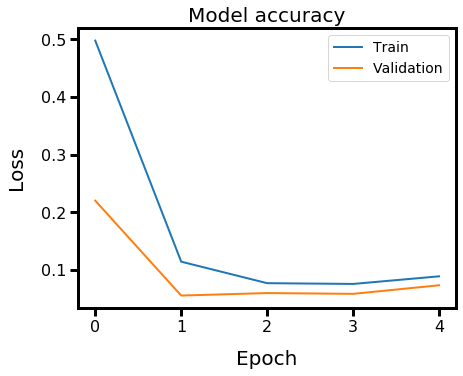

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

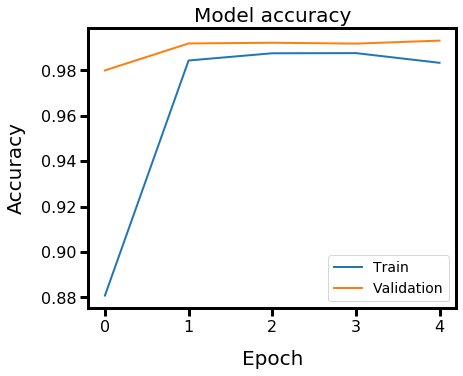

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [17]:
res_test = model.predict(X_test)

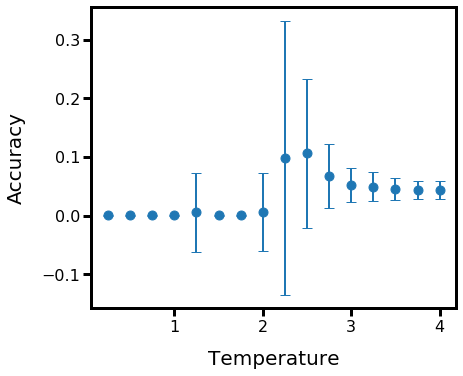

In [19]:
acc = np.zeros(temp_val.shape[0])
acc_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    
    pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
    aux = res_test[pos, 0] - Y_test[pos, 0]
    acc[idx] = np.mean(np.abs(aux))
    acc_std[idx] = np.std(np.abs(aux))

    
    
plt.errorbar(x=temp_val, y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

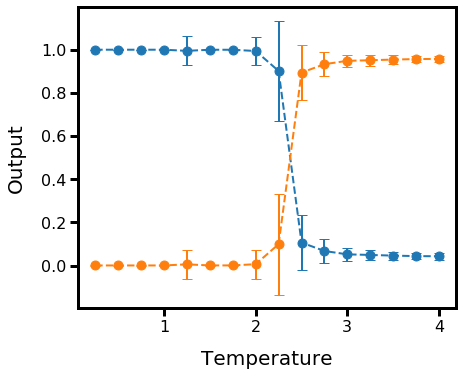

In [20]:
output_mean = np.zeros(temp_val.shape[0])
output_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
       
    pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
    output_mean[idx] = np.mean(res_test[pos])
    output_std[idx] = np.std(res_test[pos])
    
plt.errorbar(x=temp_val, y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')

plt.errorbar(x=temp_val, y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')

plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()

In [47]:
filters, biases = model.layers[0].get_weights()
filters_number = filters.shape[-1]

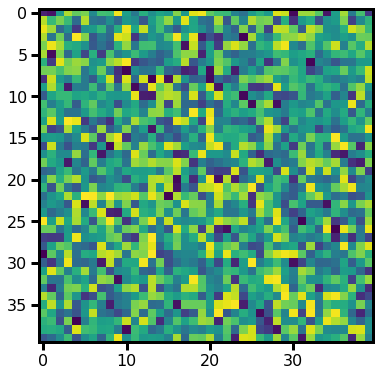

In [48]:
plt.imshow(np.reshape(filters[:, 0], (L, L)))

In [49]:
from keras.models import Model

layer = model.layers[0]

model_output = Model(inputs=model.inputs, outputs=layer.output)

In [50]:
predict = model_output.predict(X_test)

In [51]:
critical_id = np.where(Y_test==2.25)[0]
ordered_id = np.where(Y_test==1.)[0]
disordered_id = np.where(Y_test==4.)[0]

In [118]:
def plot_lattice_and_weight(X, Y, pred):
    
    fig, ax = plt.subplots(1,2, figsize=[9, 6])

    ax[0].imshow(np.reshape(X, (L, L)), origin='lower', cmap='Purples')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(r'$T= $' + str(Y))

    ax[1].imshow(np.reshape(pred, (10, 10)))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Last weights')

    fig.subplots_adjust(wspace=0.4)
    plt.show()

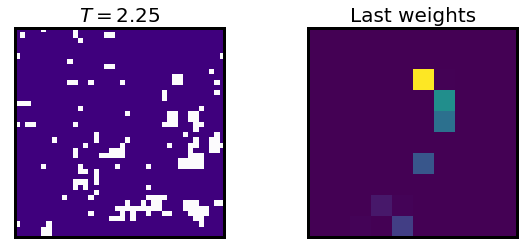

In [119]:
# Index of critical samples.
idx = -1

plot_lattice_and_weight(X_test[critical_id[idx], : ], Y_test[critical_id[idx], 1], predict[critical_id[idx]])

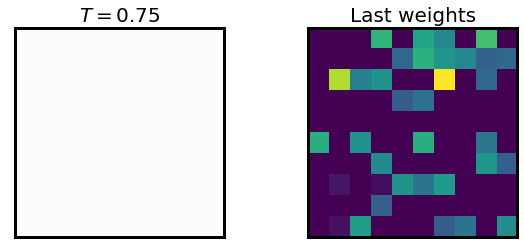

In [120]:
# Index of critical samples.
idx = -1

plot_lattice_and_weight(X_test[ordered_id[idx], : ], Y_test[ordered_id[idx], 1], predict[ordered_id[idx]])

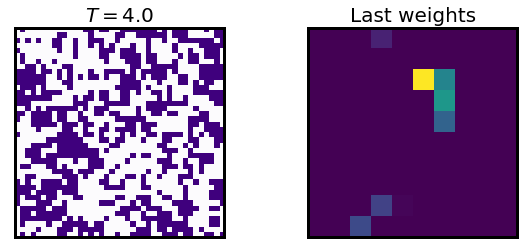

In [122]:
# Index of critical samples.
idx = -10

plot_lattice_and_weight(X_test[disordered_id[idx], : ], Y_test[disordered_id[idx], 1], predict[disordered_id[idx]])

In [123]:
#quit()